In [30]:
import requests
import json
import xarray as xr
import pandas as pd
import datetime
import matplotlib.pyplot as plt

url = 'https://beacon-cora-pr.maris.nl'
token = ''

Here we get all the available parameters that are ready for querying the footprint of the Beacon Instance.
We then print all the available parameters in the log below the code cell.

In [31]:
# Getting the available parameters through the footprint

footprint_url = f'{url}/api/datasets/footprint'

# Sending the request with the token in the header
response = requests.get(footprint_url, headers={
                        'Authorization': f'Bearer {token}'})

attributes = pd.DataFrame.from_dict(
    response.json()['unique_column_attributes'], orient='index')
attributes.reset_index(level=0, inplace=True)

attributes = attributes.sort_values(
    'index', ascending=True, key=lambda col: col.str.lower())

params = attributes['index'].to_numpy()

print(params)

['CONFIG_MISSION_NUMBER' 'CYCLE_NUMBER' 'DATA_CENTRE' 'DATA_MODE'
 'DATA_STATE_INDICATOR' 'DATA_TYPE' 'DATE_CREATION' 'DATE_UPDATE'
 'DC_REFERENCE' 'DEPH' 'DEPH_ADJUSTED' 'DEPH_ADJUSTED_QC' 'DEPH_QC'
 'DIRECTION' 'FIRMWARE_VERSION' 'FLOAT_SERIAL_NO' 'FORMAT_VERSION'
 'HANDBOOK_VERSION' 'HISTORY_ACTION' 'HISTORY_DATE' 'HISTORY_INSTITUTION'
 'HISTORY_PARAMETER' 'HISTORY_PREVIOUS_VALUE' 'HISTORY_QCTEST'
 'HISTORY_REFERENCE' 'HISTORY_SOFTWARE' 'HISTORY_SOFTWARE_RELEASE'
 'HISTORY_START_PRES' 'HISTORY_STEP' 'HISTORY_STOP_PRES' 'JULD'
 'JULD_LOCATION' 'JULD_QC' 'LATITUDE' 'LONGITUDE' 'PARAMETER' 'PI_NAME'
 'PLATFORM_NUMBER' 'PLATFORM_TYPE' 'POSITION_QC' 'POSITIONING_SYSTEM'
 'PRES' 'PRES_ADJUSTED' 'PRES_ADJUSTED_ERROR' 'PRES_ADJUSTED_QC' 'PRES_QC'
 'PROFILE_PRES_QC' 'PROFILE_PSAL_QC' 'PROFILE_TEMP_QC' 'PROJECT_NAME'
 'PSAL' 'PSAL_ADJUSTED' 'PSAL_ADJUSTED_ERROR' 'PSAL_ADJUSTED_QC' 'PSAL_QC'
 'REFERENCE_DATE_TIME' 'SCIENTIFIC_CALIB_COEFFICIENT'
 'SCIENTIFIC_CALIB_COMMENT' 'SCIENTIFIC_CALIB_DAT

In [32]:
lon_min = 0.0
lon_max = 5.0
lat_min = 51.0
lat_max = 55.0
depth_min = 0.0
depth_max = 10.0
start_date = '1950-01-01'
end_date = '2020-01-01'

parameter = 'TEMP'

In [33]:


def days_since_1950(date_str):
    # Parse the input date string to a datetime object
    input_date = datetime.datetime.strptime(date_str, '%Y-%m-%d')

    # Define the reference date: January 1, 1950
    reference_date = datetime.datetime(1950, 1, 1)

    # Calculate the difference in days
    delta = input_date - reference_date

    # Return the number of days as an integer
    return delta.days

# Building the query


query = {
    "query_parameters": [
        {
            "column_name": parameter,
            "alias": parameter,
            "optional": False,
            "skip_fill_values": True
        },
        {
            "column_name": "JULD",
            "alias": "TIME"
        },
        {
            "column_name": "DEPH",
            "alias": "DEPTH"
        },
        {
            "column_name": "LONGITUDE",
            "alias": "LONGITUDE"
        },
        {
            "column_name": "LATITUDE",
            "alias": "LATITUDE"
        }
    ],
    "filters": [
        {
            "for_query_parameter": "TIME",
            "min": days_since_1950(start_date),
            "max": days_since_1950(end_date)
        },
        {
            "for_query_parameter": "DEPTH",
            "min": depth_min,
            "max": depth_max
        },
        {
            "for_query_parameter": "LONGITUDE",
            "min": lon_min,
            "max": lon_max
        },
        {
            "for_query_parameter": "LATITUDE",
            "min": lat_min,
            "max": lat_max
        }
    ],
    "output": {
        "format": "netcdf"
    }}

In [34]:
response = requests.post(f"{url}/api/query", json.dumps(query), headers={
    'Authorization': f'Bearer {token}',
    'Content-type': 'application/json'
})

if response.status_code != 200:
    print(response.json())

# Create file to store response content
with open('./DataOutput/cora-pr-notebook-timeseries.nc', 'wb') as f:
    f.write(response.content)

# Open the netcdf file

df = xr.open_dataset(
    './DataOutput/cora-pr-notebook-timeseries.nc').to_dataframe()
df['TIME'] = pd.to_datetime(df['TIME'], unit='D', origin='1950-01-01')

<Axes: xlabel='TIME', ylabel='TEMP'>

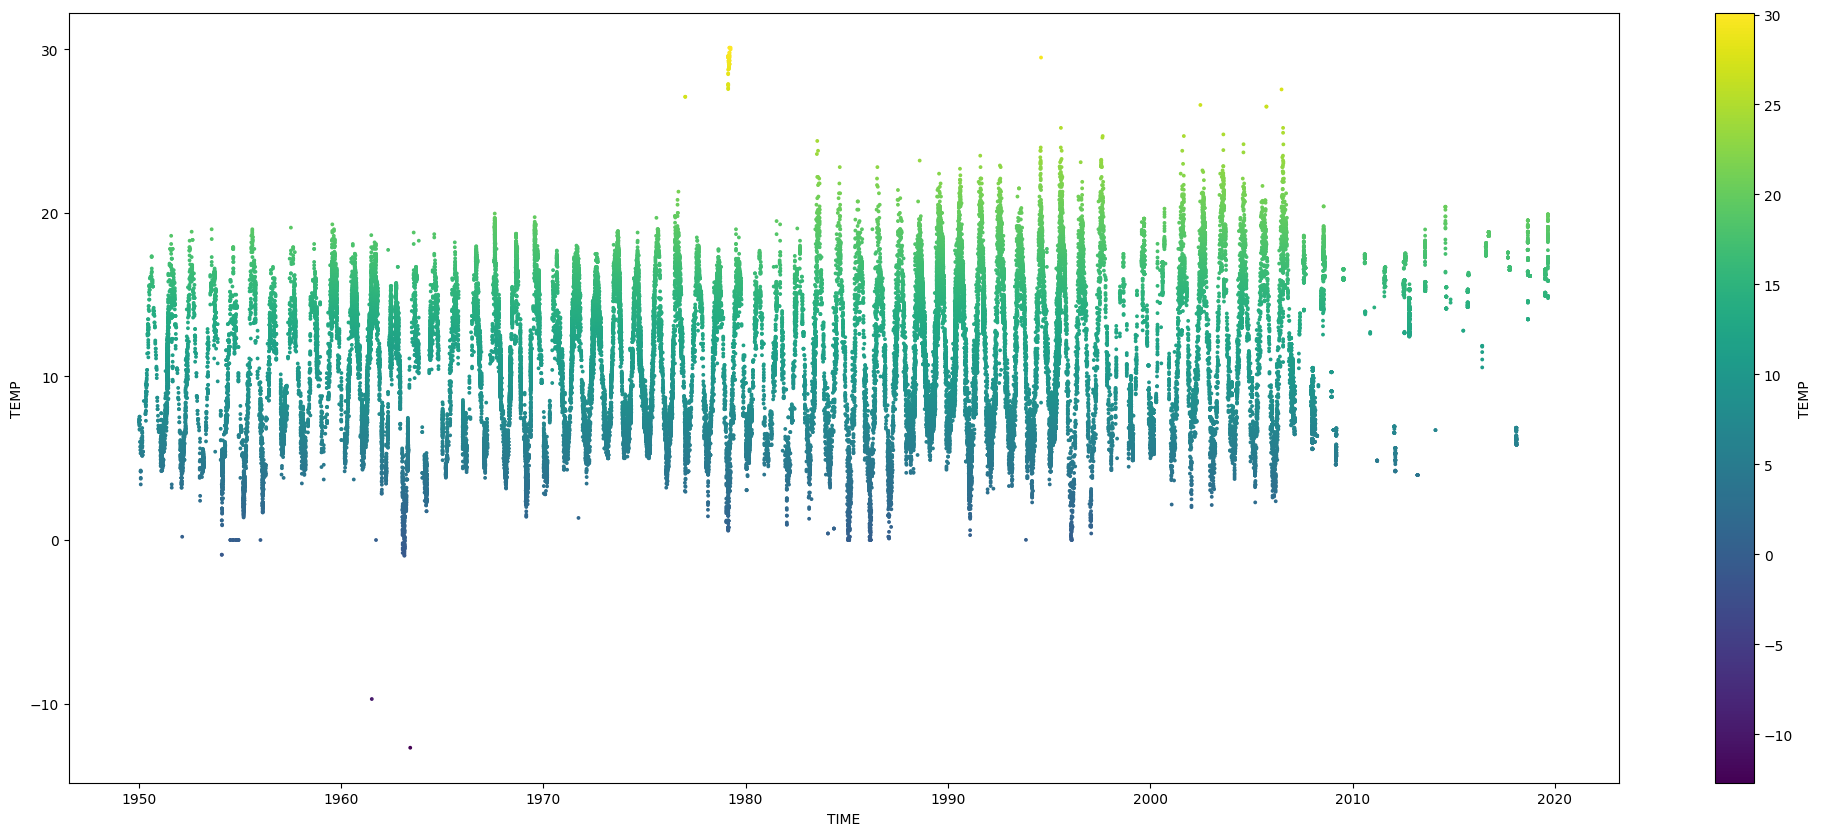

In [35]:
df.plot.scatter(cmap='viridis', x='TIME', y='TEMP',
                c='TEMP', figsize=(25, 10), s=3)

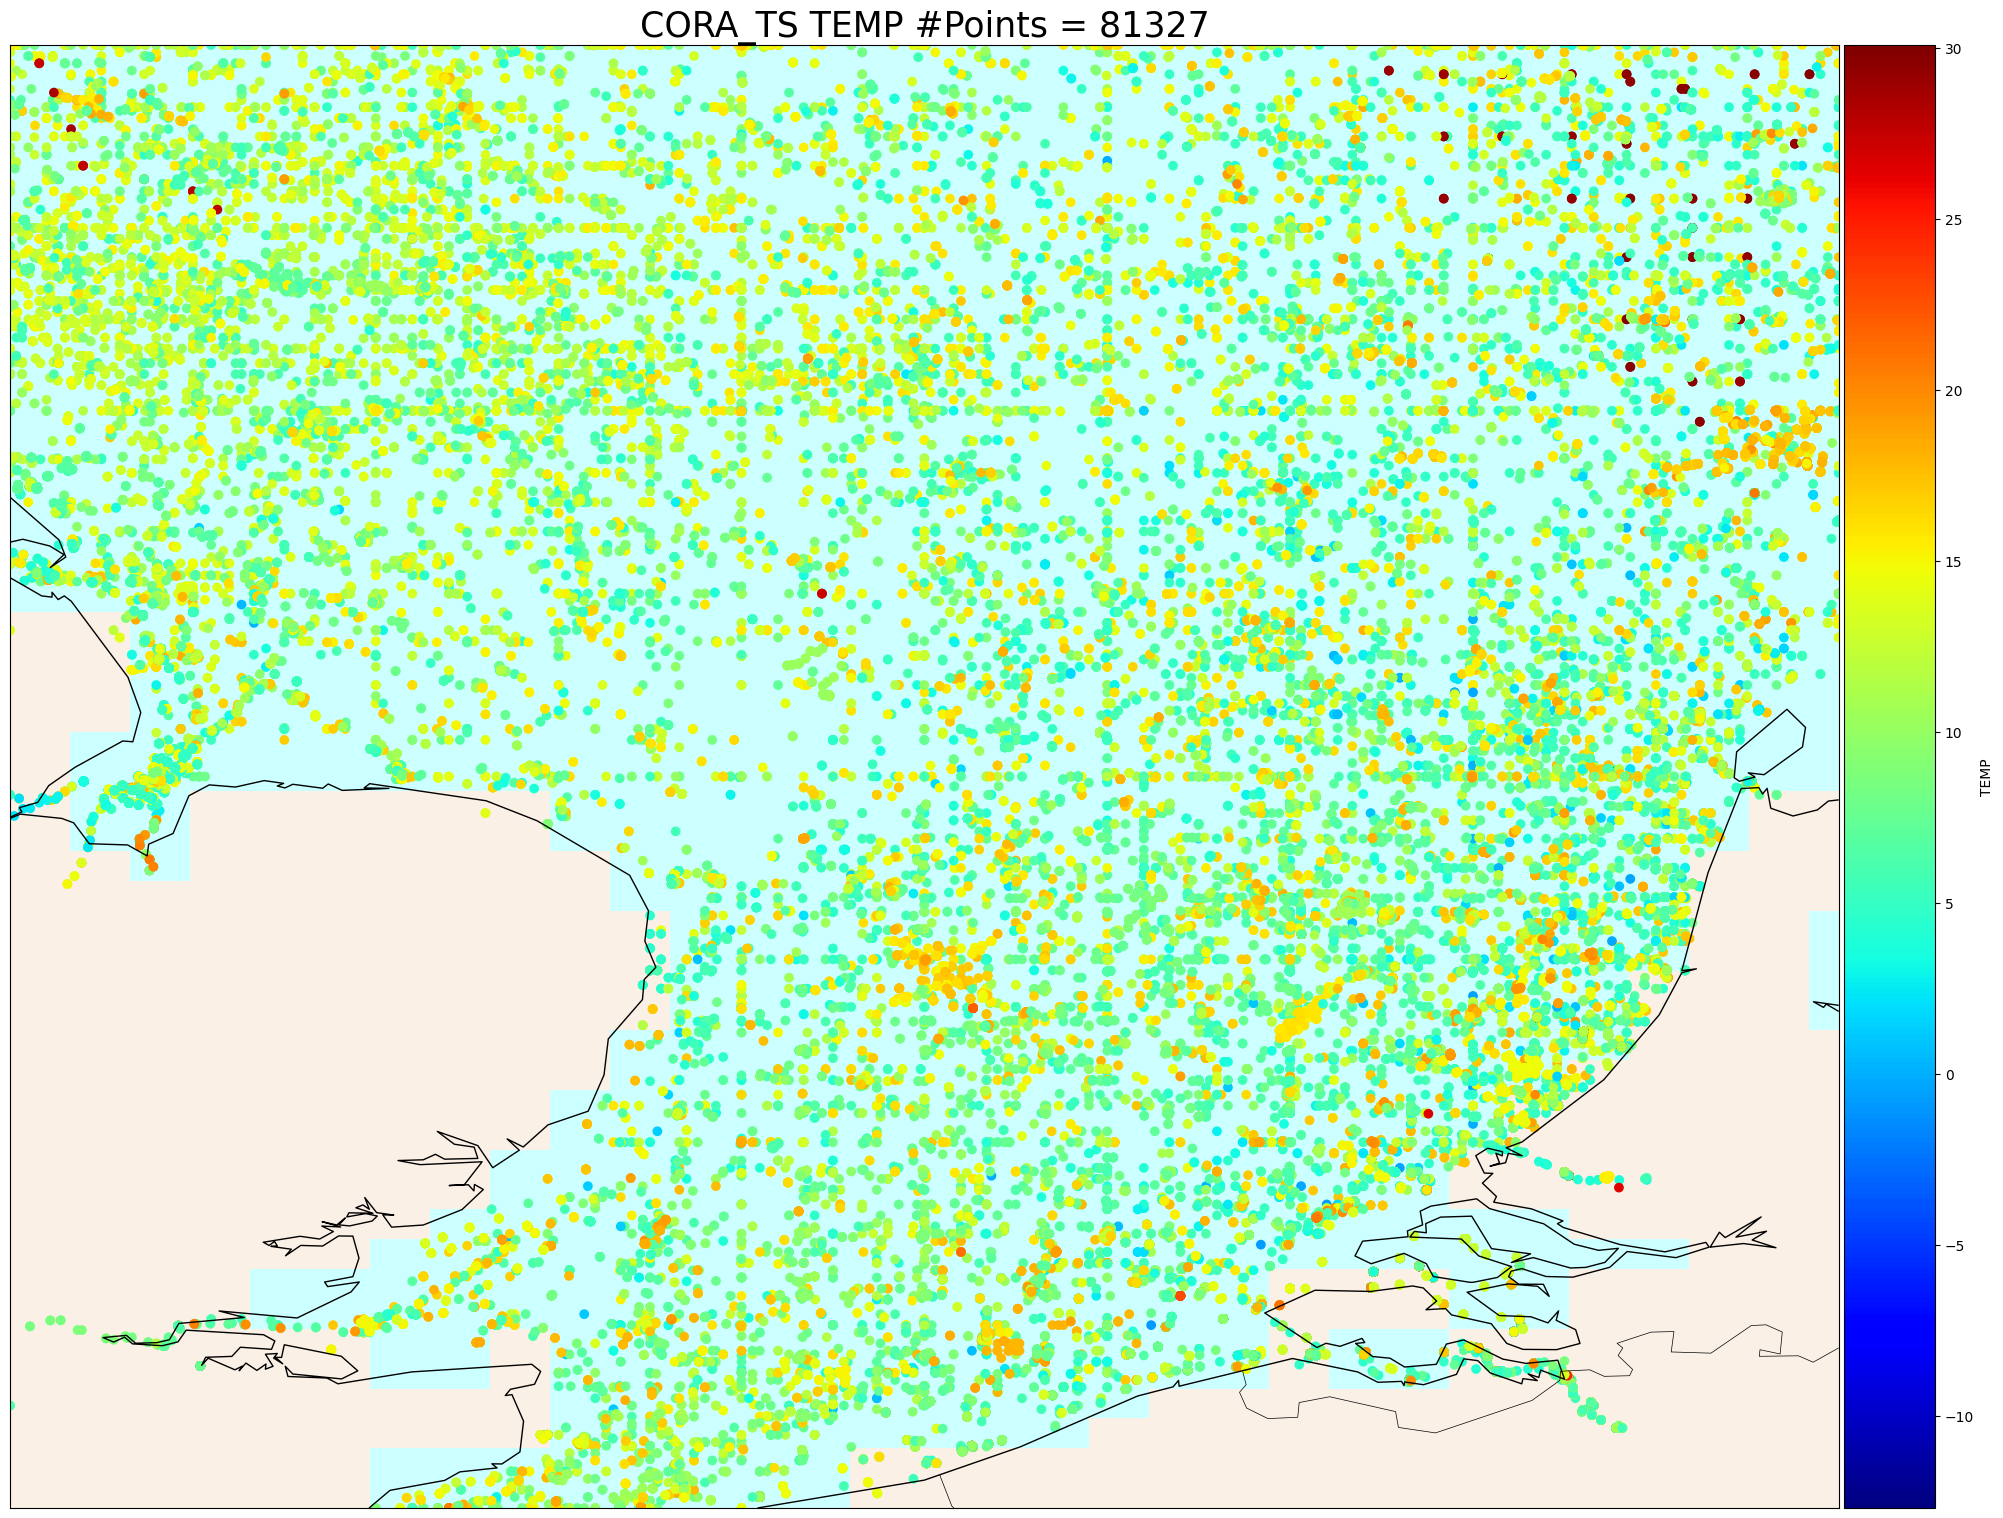

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(29, 19))

m = Basemap(projection='cyl', llcrnrlon=lon_min, llcrnrlat=lat_min,
            urcrnrlon=lon_max, urcrnrlat=lat_max, resolution='i')
# can use HTML names or codes for colors
m.drawlsmask(land_color='Linen', ocean_color='#CCFFFF')
m.drawcoastlines()
m.drawcountries()

sc = m.scatter(df['LONGITUDE'], df['LATITUDE'], latlon=True,
               c=df[f'{parameter}'], cmap=plt.cm.jet)

plt.title(
    f'CORA_TS {parameter} #Points = {len(df)}', fontsize=25)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc, cax=cax, label=f'{parameter}')